## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)

import numpy as np
import cv2
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import skimage.feature as skimg
import sklearn
from common import showImages
from feature import Feature
from train import Classifier
from train import Trainer
from search import Search

Populating the interactive namespace from numpy and matplotlib


## **Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf. 

You're reading it!

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for this step is contained **feature.py** between lines 56-70. 

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:


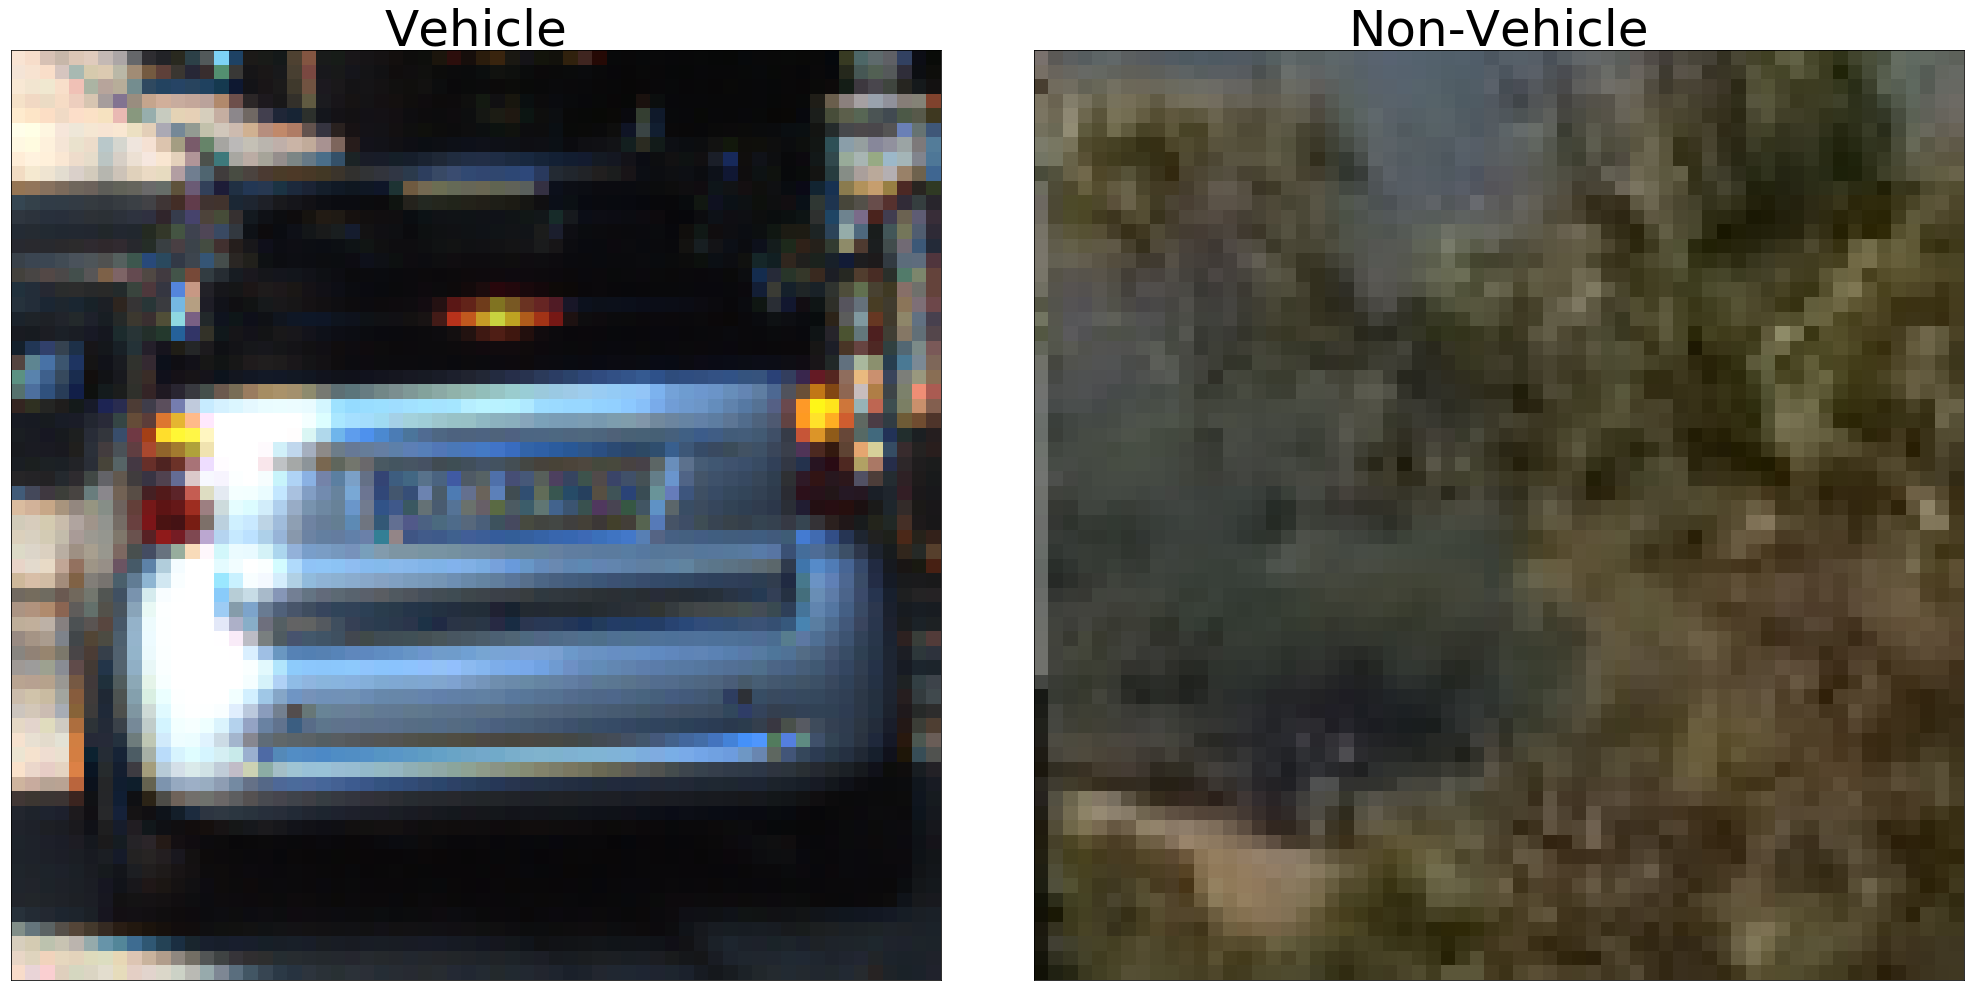

In [4]:
# load vehicle data
v_path = glob.glob('./data/vehicles/607.png')[0]
nv_path = glob.glob('./data/non-vehicles/extra10.png')[0]
v_img = mpimg.imread(v_path)
nv_img = mpimg.imread(nv_path)
showImages([v_img, nv_img], 1, 2, col_titles=["Vehicle",'Non-Vehicle'])

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


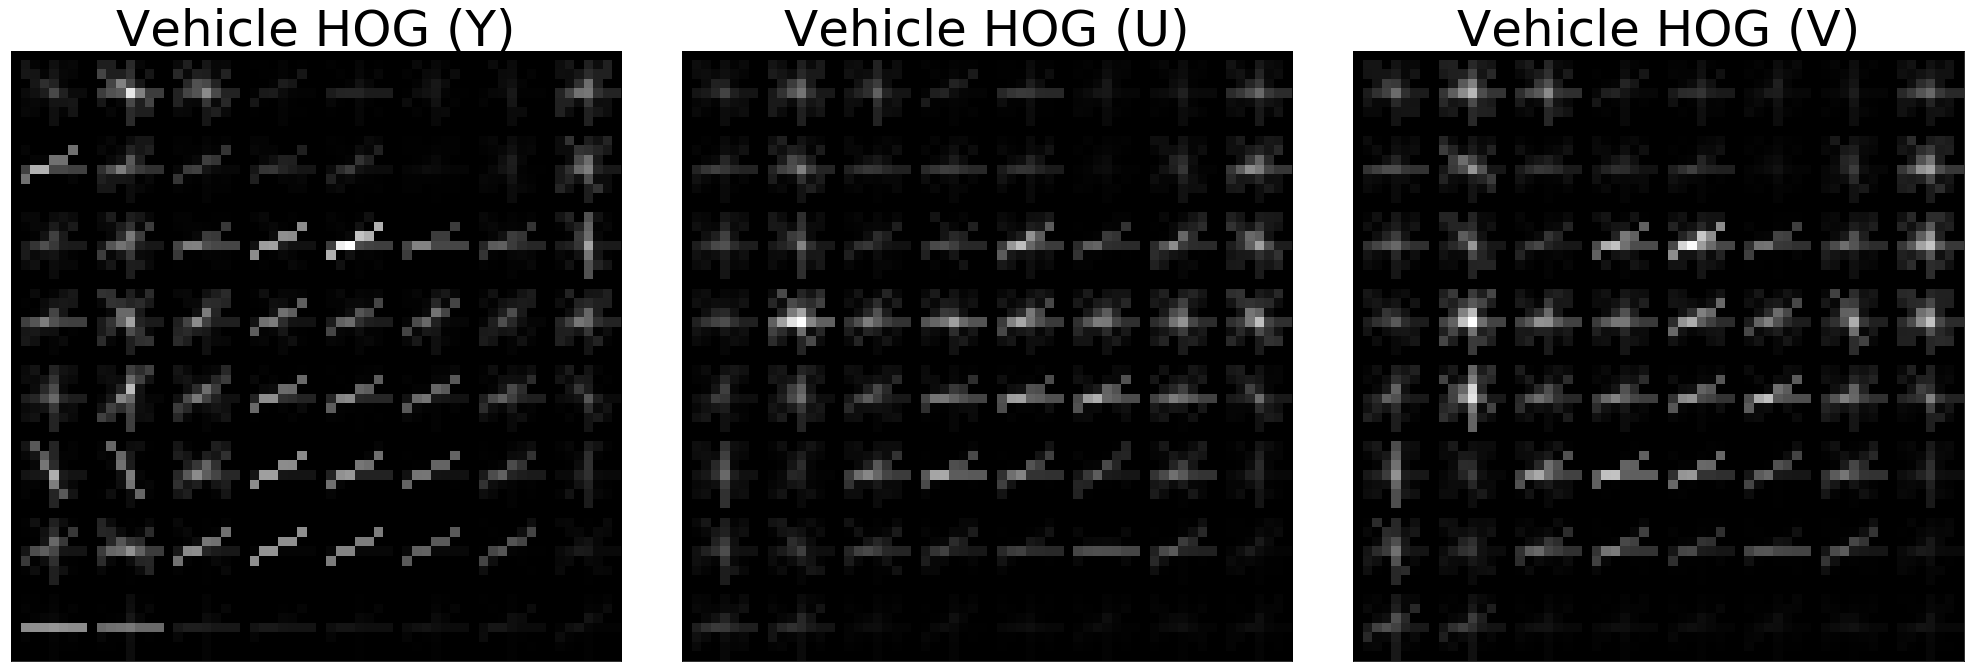

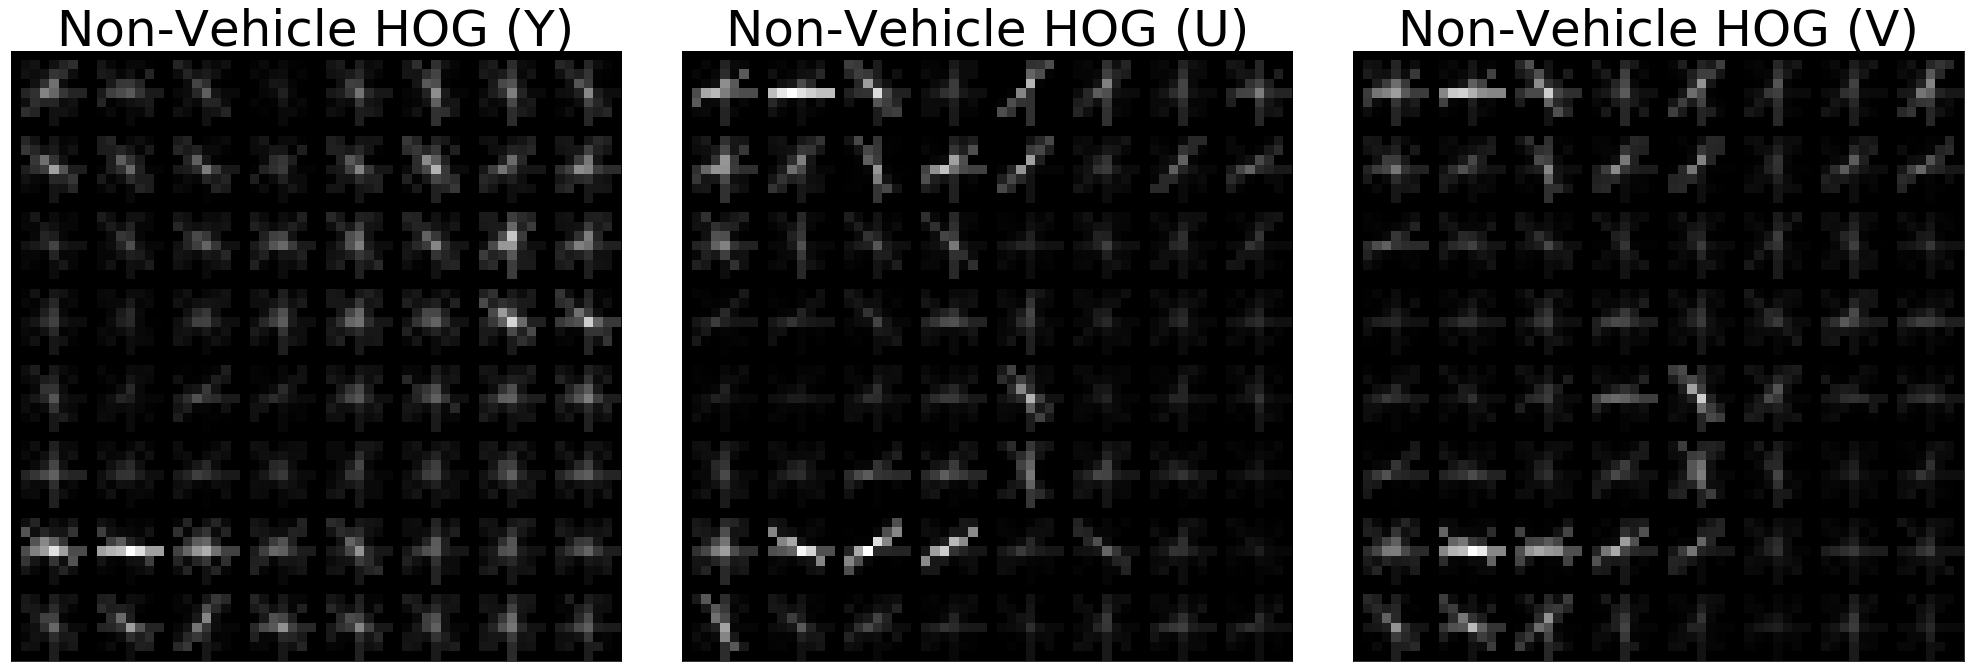

In [10]:
orient=8
pix_per_cell=8
cell_per_block=2
v_yuv_img = cv2.cvtColor(v_img, cv2.COLOR_RGB2YUV)
nv_yuv_img = cv2.cvtColor(nv_img, cv2.COLOR_RGB2YUV)
features, v_hog_img_y = skimg.hog(v_yuv_img[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, nv_hog_img_y = skimg.hog(nv_yuv_img[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, v_hog_img_u = skimg.hog(v_yuv_img[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, nv_hog_img_u = skimg.hog(nv_yuv_img[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, v_hog_img_v = skimg.hog(v_yuv_img[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, nv_hog_img_v = skimg.hog(nv_yuv_img[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
showImages([v_hog_img_y, v_hog_img_u, v_hog_img_v], 1, 3, cmap='gray', col_titles=['Vehicle HOG (Y)', 'Vehicle HOG (U)', 'Vehicle HOG (V)'])
showImages([nv_hog_img_y, nv_hog_img_u, nv_hog_img_v], 1, 3, cmap='gray', col_titles=['Non-Vehicle HOG (Y)', 'Non-Vehicle HOG (U)', 'Non-Vehicle HOG (V)'])

#### 2. Explain how you settled on your final choice of HOG parameters.

I experimented with the parameters empirically to find the best results given the training and test set data along with performance considerations.

I chose orientations=9 because it offers a good balance of generalizing the orientation directions and it offers a central bin for orientation centered around the '0' position, whereas a even value would have a discontinuity around the 0 position between two bins. Since many HOG orientations align to 0, it's best to use and odd value to group these 0 centered orientation into one group.

I chose cells_per_block=2 after experimentation. It offers some contrast normalization of the HOG vectors but increasing it beyond 2 did not have much meaning effect for the increased memory consumption.

Cells per block was set to 8. This is a good balance for the scale of the detections in this project since the cars in the video appear at small resolutions (64x64). It also is small enough, but not too small, so that a sliding detection window can align to cell boundaries. Increasing this beyond 8 would offer speedier performance and reduced memory requirements, however it would also over-generalize the HOG orientations for the lower sample source images that were provided (64x64). At this resolution and cell size, the model can be trained to use an 8x8 grid to determine the car's shape. 

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using gradient descent (SGDGradientClassifier) by spliting up a the sample data into training and validation sets. I used the default SVM parameters provided by sklearn, which attempts to find a hyperplane that best linearly separates the data into two regions for classification. The SVM find the correct 'support vector' data points that are closest to the hyperplane and adjusts the margin between these data points to plane to offer the best decision surface. I trained the model for several iterations until the accuracy was high enough on the validation set for use in the classification task. For the SVM, I made sure to use ***StandardScaler*** to center mean and standardize the feature set before training and to also transform the test data by the same scaling factor before calculating predictions.

For features, I experiemented with different color spaces, but found that HLS and YUV (YCrCb) offered the best performance. YCrCb has a nice property of selecting a car by its tail lights which stand out well in the 'redness channel'. HLS is also good since cars then to have high saturation colors. I chose YUV as the foundation color space and then extracted histogram data and processed all 3 channels for HOG features. I chose not to the use the spatial data since the HOG features generalize better across translations and orientation shifts of the object within the image.

The code for the classifier is found in **train.py** between lines 85-182.

#### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I implemented a sliding search which would operate within region of interest and scan left to right as well as up and down through the image. At each step of the sliding window, the classifier is run by rescaling the sub-image within the window down the original sample size, then extracting the features from the sub-image and feeding them into the SVM. The results would be a prediction with a score, which represents how far away the prediction is from the decision hyperplace.

The sliding window search is repeated at different window sizes so that it can detect objects at different scales within the image. I chose to slide the window at 5 different scales between 64x64 to 256x256 with a heavy overlap of 87.5%. I chose the window scale values because the cars in the sample videos were represented at these scales. The overlap was chosen so that it would be an even factor of 8 (the cell size) at all the scales. The overlap is aggressive so that overlapping bounding boxes could be calculated to tightly align with the object.

The sliding window search is implemented within **search.py** at line 103. The HOG optimized extraction is found within **feature.py** at line 175.


#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

I optimized the performance of my classifier by hand selecting various training samples from the 'extras' set which better represents the data in the test video. I also tuned the performance by experimenting with different features and hyperparameters and chose the best mix while eliminating features that were not linearly independent. The color spatial features did not assist with a better classifier, but the color histogram did help. I also retrained the model a few times using hard negative mining by gather false positives, adding them to the training set and re-running the training session. 

Also as an optimization, I implemented a HOG-optimized sliding search by calculating all the HOG features in the current search image and then subsampling the precomputed HOG features along the sliding window. THis would eliminate many redundant calculations caused by the overlap between windows.

Below are some examples of the classifier at work, demonstrating the intermediate bounding box detections, heatmaps, and final detection. The detections image illustrates the positive detection bounding boxes by the sliding window algorithm, scaled by its score. Lower confidence detections are more transparent, and strong predictions will appear whiter. Many detections overlap, building a stronger prediction model in the heatmap phase with each detection offering a weighted vote based on the prediction score.

Number of hits:  283  min/max score 1.815, 1665.201


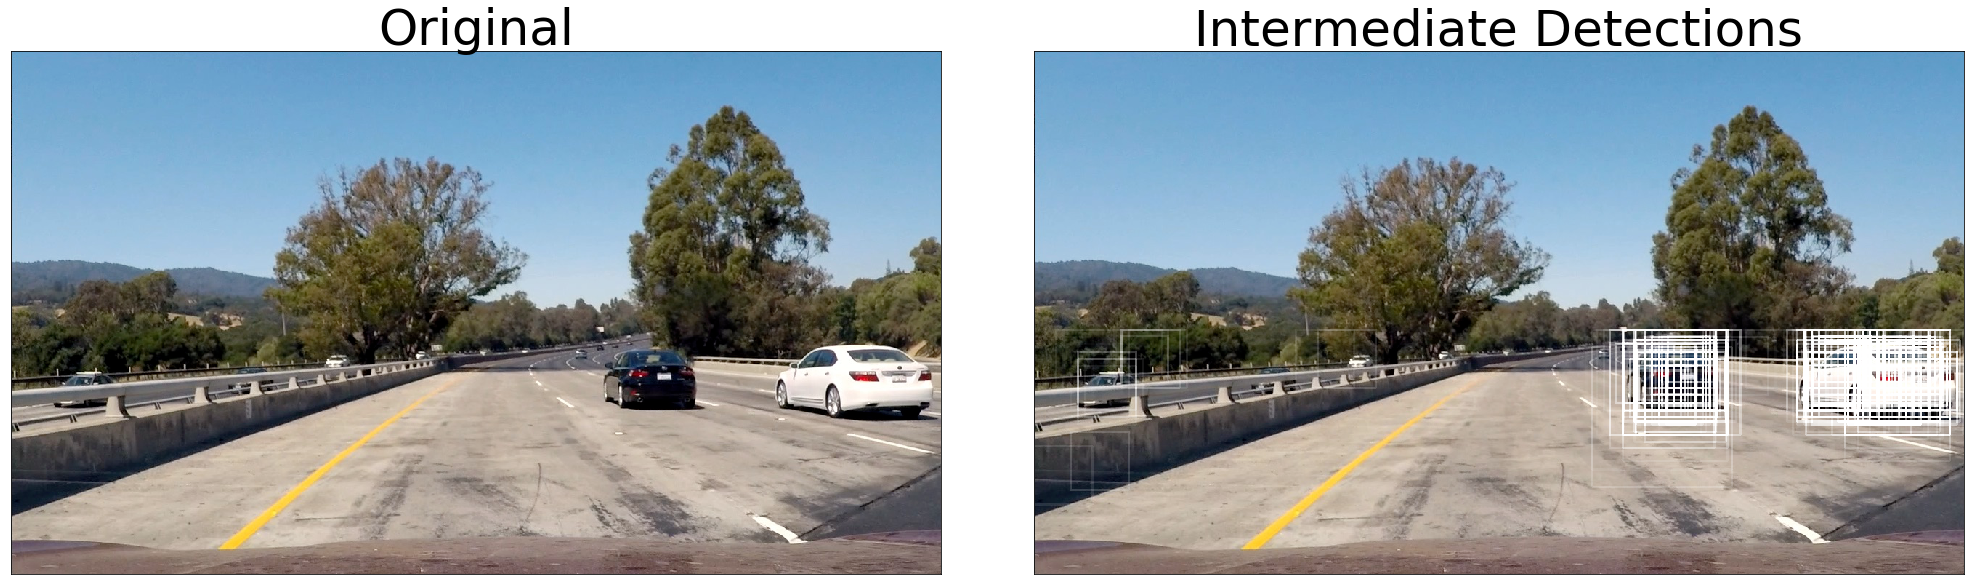

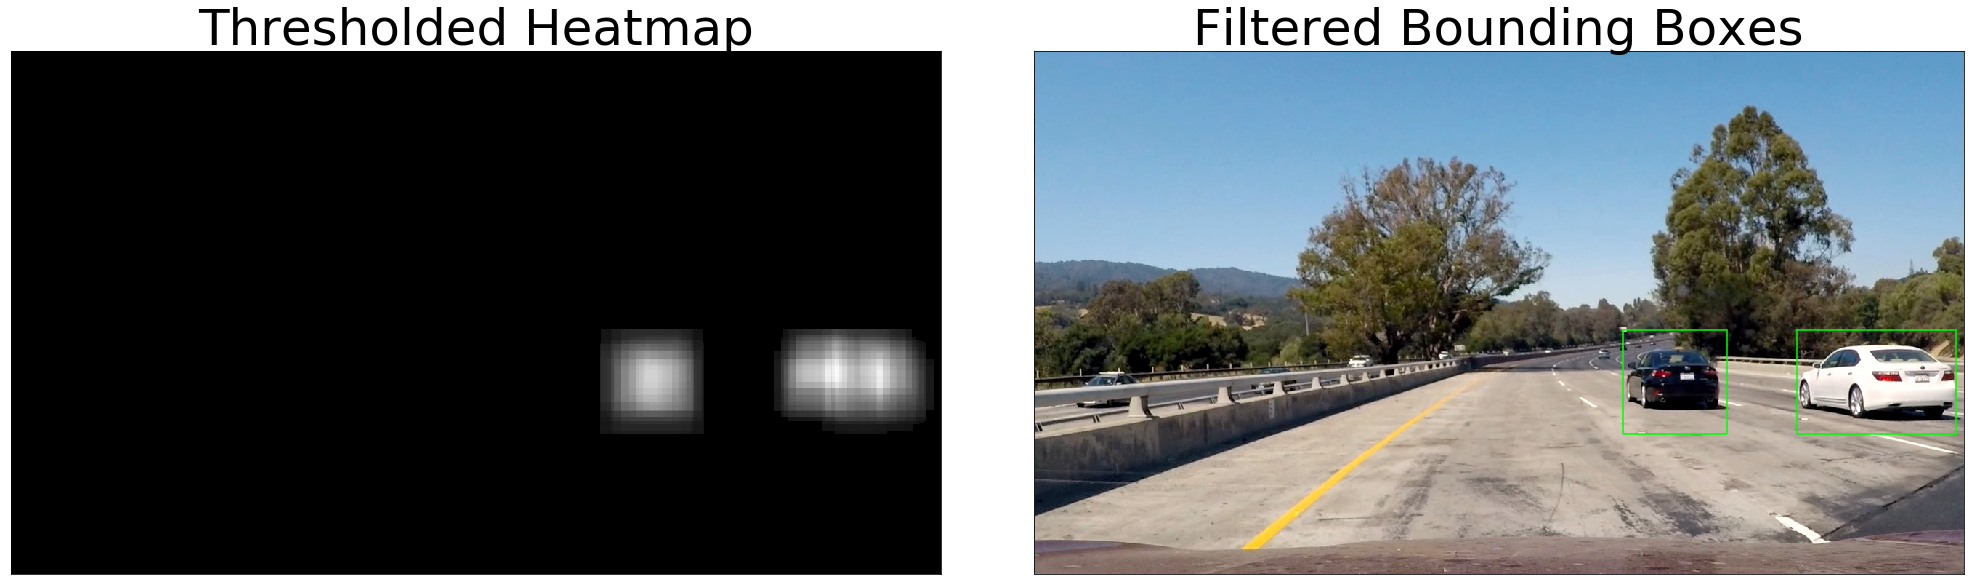

In [33]:
classifier = Classifier()
classifier.load('models/final')
f_ex = Feature(
    sample_size=(64,64), hist_bins=64, 
    spatial_size=None, useMeanAndStd=False, 
    cspaces=['YUV'], useHog=True, hog_bins=9, hog_cell_size=8, hog_block_size=2
)
trainer = Trainer(f_ex, classifier)
search = Search(f_ex, trainer, 256, 64, 8, overlap_factor=0.875)
search_img_path = glob.glob('./test_images/test1.png')
search_img = mpimg.imread(search_img_path[0])

windows, scores, windows_count = search.search(search_img, ((0, 384), (1280, 640)))
print('Number of hits: ', len(windows), ' min/max score {:.3f}, {:.3f}'.format(np.min(scores), np.max(scores)))

score_alphas = scores / np.max(scores)
bbox_img = Search.draw_boxes(search_img, windows, alphas=score_alphas, thick=2)

heatmap = np.zeros_like(search_img, dtype=np.float32)
search.add_heat(heatmap, None, windows, scores)
heatmap[heatmap < 3000] = 0
heatmap /= np.max(heatmap) + 0.00001

car_bboxs = search.filter_boxes(heatmap)
car_bbox_img = Search.draw_boxes(search_img, car_bboxs, color=(0, 255, 0), alpha=0.75, thick=2)

showImages([search_img, bbox_img], 1, 2, col_titles=['Original', 'Intermediate Detections'])
showImages([heatmap, car_bbox_img], 1, 2, col_titles=['Thresholded Heatmap', 'Filtered Bounding Boxes'])

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Here's a [link to my video result](https://youtu.be/Yub_pUa9Zxs)

In the video, the HUD at the top shows heatmaps for the detections, the left is the historical heat map, the right is the immediate heat map for the current frame.


#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

For overlaping detections, I recorded the positions of positive detections in each frame of the video and the prediction score for that detection.  From the positive detections I created a heatmap that accumlated the prediction score and then thresholded that map to identify vehicle positions. The thresholding eliminates weaker values between the local maximas that define the centroids of the detected objects; this helps to segment the objects from each othen, after which `scipy.ndimage.measurements.label()` was used to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

For false positives, the thresholding of the heatmap helps eliminate many false positives. I also filter out areas from the heap map that are too small to be considered. For the more difficult false positives, I integrate the heatmap over several frames and apply a threshold value over the averaged heat map so that strong positive cases will stand out over weaker false positives based on the score accumulated in that region.

The filtering code is found in **pipeline.py** between lines 52-70.

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

I found optimizing this code to be quite difficult while still trying to make progress and tune the output accordingly. I would improve my code so that the sliding search would only consider smaller scales for areas father in the z-plane (higher in the y-cordinate space) and larger ones for areas closer to the camera.

My pipeline would likely fail in areas with far more contrasting features and more colorful environments like city streets. The classifier is not tuned well with enough data to be robust enough for other environments. A CNN would be a better choice for object classification and I would opt to replace the classifier for one.

The heatmap integration would likely fail for fast moving objects in relation to the camera framerate. 
